In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('data/x_train.csv')
df2 = pd.read_csv('data/y_train.csv')
x_train = df.iloc[:, -25:].copy()
y_train = df2.iloc[:, -25:].copy()

filter1 = pd.read_json('filter.json')

In [8]:
# x_train.iloc[:, 14:].head() # Take the filtered features instead
x_train_f = x_train[list(filter1["title"])] # doesn't work

KeyError: "['CELLFON3', 'GENHLTH', 'PHYSHLTH', 'MENHLTH', 'POORHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BPMEDS', 'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', 'MARITAL', 'EDUCA', 'RENTHOM1', 'NUMHHOL2', 'CPDEMO1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2', 'WEIGHT2', 'HEIGHT3', 'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'STOPSMK2', 'LASTSMK2', 'USENOW3', 'ALCDAY5', 'AVEDRNK2', 'DRNK3GE5', 'MAXDRNKS', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'VEGETAB1', 'EXERANY2', 'EXRACT11', 'EXEROFT1', 'EXERHMM1', 'STRENGTH', 'LMTJOIN3', 'ARTHDIS2', 'JOINPAIN', 'FLUSHOT6', 'FLSHTMY2', 'PNEUVAC3', 'HIVTST6', 'HIVTSTD3', 'PDIABTST', 'PREDIAB1', 'INSULIN', 'BLDSUGAR', 'FEETCHK2', 'DOCTDIAB', 'CHKHEMO3', 'DIABEYE', 'DIABEDU', 'CAREGIV1', 'CRGVREL1', 'CRGVPRB1', 'VINOCRE2', 'CIMEMLOS', 'WTCHSALT', 'LONGWTCH', 'DRADVISE', 'ASTHMAGE', 'ASATTACK', 'ASDRVIST', 'ASRCHKUP', 'ASACTLIM', 'ASYMPTOM', 'ASNOSLEP', 'ASTHMED3', 'ASINHALR', 'HAREHAB1', 'STREHAB1', 'CVDASPRN', 'ASPUNSAF', 'RLIVPAIN', 'RDUCHART', 'RDUCSTRK', 'ARTTODAY', 'ARTHWGT', 'ARTHEXER', 'ARTHEDU', 'TETANUS', 'HPVADVC2', 'SHINGLE2', 'HADMAM', 'HOWLONG', 'HADPAP2', 'LASTPAP2', 'HPVTEST', 'HPLSTTST', 'HADHYST2', 'PROFEXAM', 'LENGEXAM', 'BLDSTOOL', 'HADSIGM3', 'LASTSIG3', 'PCPSARE1', 'PSATEST1', 'PSATIME', 'SCNTMNY1', 'SCNTMEL1', 'SCNTWRK1', 'SCNTLWK1', 'SXORIENT', 'TRNSGNDR', 'EMTSUPRT', 'LSATISFY', 'ADPLEASR', 'ADDOWN', 'ADSLEEP', 'ADENERGY', 'ADEAT1', 'ADFAIL', 'ADTHINK', 'ADMOVE', 'MISTMNT', 'ADANXEV', 'QSTLANG', 'MSCODE', '_CHISPNC', '_DUALUSE', '_RFHLTH', '_RFHYPE5', '_MICHD', '_PRACE1', '_MRACE1', '_RACE', '_AGEG5YR', '_BMI5CAT', '_CHLDCNT', '_EDUCAG', '_INCOMG', '_SMOKER3', '_RFSMOK3', 'DRNKANY5', 'DROCDY3_', '_RFBING5', 'DRNKWEK', '_RFDRHV5', '_FRTLT1', '_VEGLT1', '_TOTINDA', 'ACTIN11_', 'ACTIN21_'] not in index"

## Correlation

<Axes: >

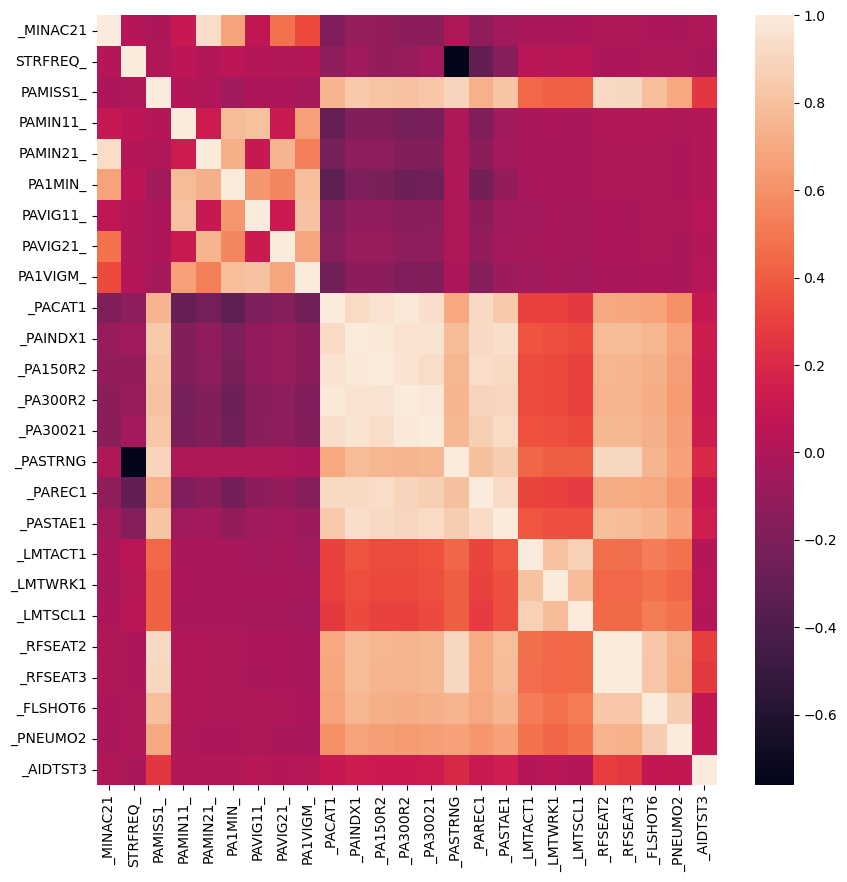

In [ ]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(x_train.corr(), fmt='.2f')

# 2nd filter makes a set with the features that are not correlated with each other

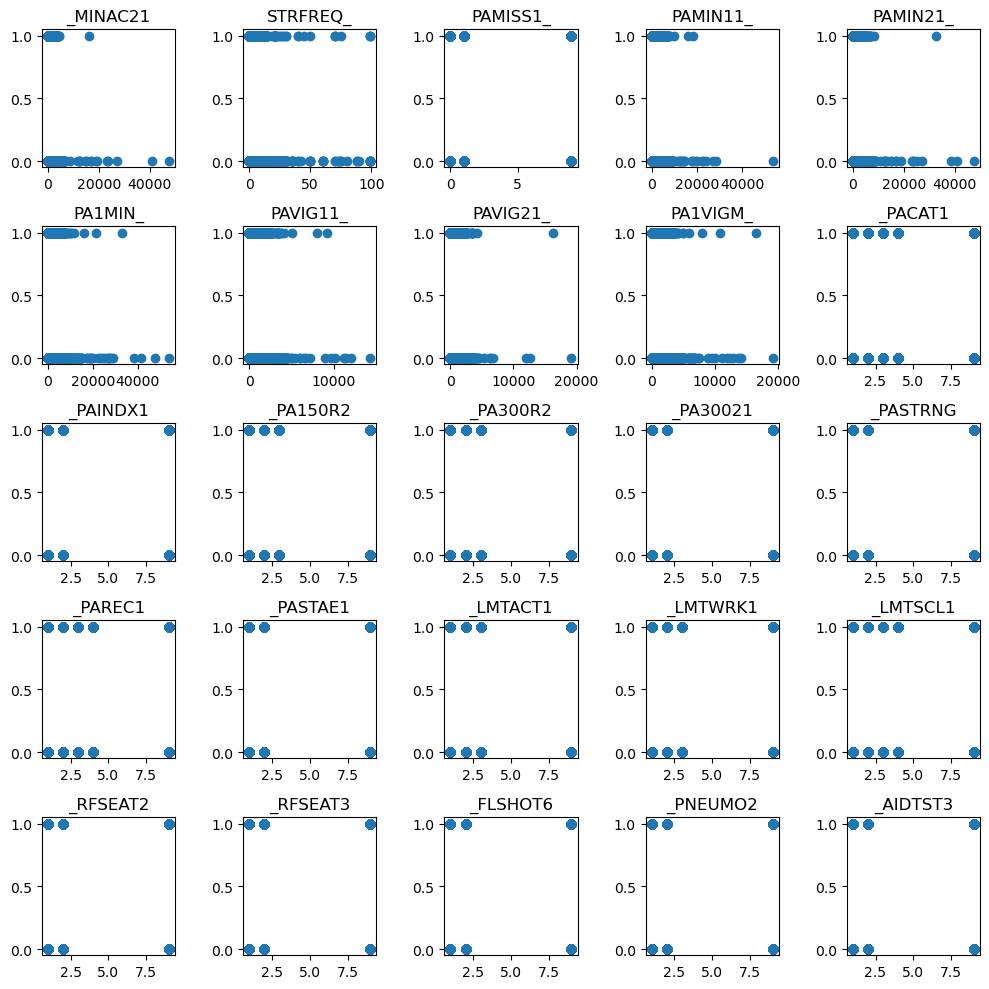

In [ ]:
features = x_train.columns
rows, cols = [int(len(features)**0.5)]*2
fig, axes = plt.subplots(rows, cols, figsize=(10, 10), tight_layout=True)
count = 0
for i in range(rows):
    for j in range(cols):
        axes[i, j].scatter(x_train.iloc[:, count], y_train)
        axes[i, j].set_title(features[count])
        count += 1